# Monty Hall Problem (p178)

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

Authors: <b>Aymen Merrouche</b> and Pierre-Henri Wuillemin.

**This notebook follows the example from "The Book Of Why" (Pearl, 2018) chapter 6 page 178**

In [1]:
from IPython.display import display, Math, Latex,HTML

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt

> Assume that you are playing a game that consists of choosing, among three doors, one to open, revealing the prise you won. Behind one of the three doors is a car and behind the two others are goats. After making your choice, the host opens one of the two remaining doors behind which is a goat. Do you want to change your choice?

The host can't choose the winning door. Let's enumerate all the possible cases: 
<table>
    <caption> Suppose that you choose door 1 </caption>
    <tr> <th>Door 1 </th> <th>Door 2 </th><th>Door 3 </th><th>outcome if you switch</th><th>outcome if you stay</th> </tr>
    <tr><td>auto</td><td>goat</td><td>goat</td><td>loose</td><td>win</td></tr>
    <tr><td>goat</td><td>auto</td><td>goat</td><td>win</td><td>loose</td></tr>
    <tr><td>goat</td><td>goat</td><td>auto</td><td>win</td><td>loose</td></tr>
</table>

## Version 1

### Simulation of Version1

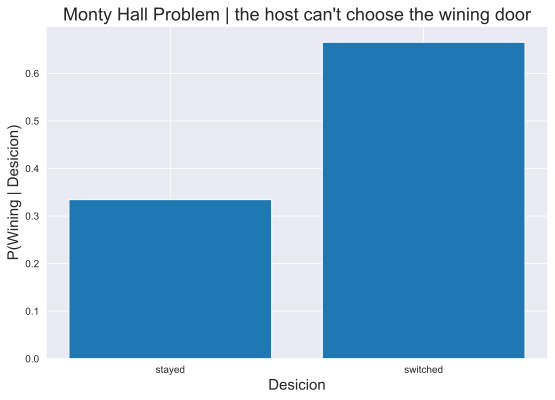

In [2]:
switched = 0
stayed = 0
gains = {"stayed" : 0, "switched" : 0}

for nbsim in range(10001) :
    # there are three doors in total
    doors = [1,2,3]

    # the car location
    carLocation = random.randint(1,3)
    
    # Your choice
    choice = random.randint(1,3)
    
    # The host can't choose your door
    doors.remove(choice)
    
    # The host can't choose the wining door either
    if carLocation != choice :
        doors.remove(carLocation)
        
    # The host's choice :
    host = random.choice(doors)
    
    # if you picked the right door in the first place
    if choice == carLocation :
        gains["stayed"] += 1
    else : 
        gains["switched"] += 1
        
gains["stayed"] = gains["stayed"] / nbsim
gains["switched"] = gains["switched"] / nbsim



#style du plot
sns.set_style('darkgrid')
#taille des lables
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
#taille de la figure
plt.figure(figsize=(9,6), dpi = 100)
plt.xlabel('Desicion', fontsize = 15)
plt.ylabel('P(Wining | Desicion)', fontsize=15)
#titre
plt.title('Monty Hall Problem | the host can\'t choose the wining door', fontsize=18)
plt.bar(gains.keys(), gains.values())
plt.show()

 $P(wining \mid swithed) = \frac{2}{3}$ <br>
 $P(wining \mid stayed) = \frac{1}{3}$ <br>
> How is that? How can systematically changing my choice be favorable? When the host opens the door, I am left with two choices, this means I have a $\frac{1}{2}$ probability of winning if I switch and a $\frac{1}{2}$ probability of winning if I stick to my choice. 

### Causal diagram for Version 1
The host can't pick the winning door, so the variable "Door opened" has two causes, if you choose a door it can't be opened ($Your Door \rightarrow Door Opened$) and the host can't pick the door behind which the car is ($Location Of The Car \rightarrow Door Opened $). The corresponding causal diagram is the following:

In [3]:
v1 = gum.fastBN("Your Door[1,3]->Door opened[1,3]<-Location of the car[1,3]")
v1

(pyAgrum.BayesNet@0x1168bd200) BN{nodes: 3, arcs: 2, domainSize: 27, dim: 22, mem: 264o}

In [4]:
# We fill the CPTs

# You make a random choice
v1.cpt("Your Door")[:] = [1/3,1/3,1/3]
# The winning door is randomly chosen
v1.cpt("Location of the car")[:] = [1/3,1/3,1/3]

# The host can't open your door, he can't open the winning door either
v1.cpt("Door opened")[{'Your Door':'1','Location of the car':'1'}] = [0,0.5,0.5] 
v1.cpt("Door opened")[{'Your Door':'1','Location of the car':'2'}] = [0,0,1]
v1.cpt("Door opened")[{'Your Door':'1','Location of the car':'3'}] = [0,1,0]

v1.cpt("Door opened")[{'Your Door':'2','Location of the car':'1'}] = [0,0,1] 
v1.cpt("Door opened")[{'Your Door':'2','Location of the car':'2'}] = [0.5,0,0.5]
v1.cpt("Door opened")[{'Your Door':'2','Location of the car':'3'}] = [1,0,0] 

v1.cpt("Door opened")[{'Your Door':'3','Location of the car':'1'}] = [0,1,0] 
v1.cpt("Door opened")[{'Your Door':'3','Location of the car':'2'}] = [1,0,0]
v1.cpt("Door opened")[{'Your Door':'3','Location of the car':'3'}] = [0.5,0.5,0] 

Suppose that you choose door number 1, and the host opens door number 3:

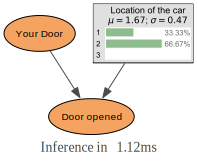

In [5]:
gnb.showInference(v1,targets={"Location of the car"}, evs = {'Your Door':'1', 'Door opened': '3'})

> It is confirmed by the Bayesian network, <b>systematic change of choice is the best strategy</b>!  

In the beginning, I have to choose between three doors with no prior knowledge: 

$P(Location Of The Car = 1) = \frac{1}{3}$ $P(Location Of The Car = 2) = \frac{1}{3}$ $P(Location Of The Car = 3) = \frac{1}{3}$ 

I choose to open door number 1.

The host opens door number 3, knowing that he can't pick the winning door, we get: 

$P(DoorOpened = 3 \mid LocationOfTheCar = 3) = 0$ $P(DoorOpened = 3 \mid LocationOfTheCar = 2) = 1$ $P(DoorOpened = 3 \mid LocationOfTheCar = 1) = \frac{1}{2}$ 

We apply Bayes' rule:
$P(LocationOfTheCar = 2 \mid DoorOpened = 3) = \frac{P(DoorOpened = 3 \mid LocationOfTheCar = 2)\times P(LocationOfTheCar = 2)}{\sum_{i=1}^{3}{P(DoorOpened = 3 \mid LocationOfTheCar = i) \times P(LocationOfTheCar = i)}} = \frac{1 \times \frac{1}{3}}{\frac{1}{3} \times (0+1+\frac{1}{2})} = \frac{2}{3} $

> This is explained by collider bias. "Door Opened" is a collider, once we know this information it's as if we are controlling for it, opening a non-causal path between "Your Door" and "Location of the car." If you choose door number 1, and the host opens door number 3 then it is twice as likely that the car is located behind door number 2. That is because the host must not pick the winning door, why did he pick door number 3 and not door number 2? Maybe because door number 2 is the winning door. But the host didn't need to make such a choice between the door you chose and door number 3.

## Version 2:

In this version of the game the host picks the door randomly (including the door behind which the car is), there are 6 cases to enumerate. Again, we will only account for cases where the host opens one of the two remaining doors revealing a goat.

### Simulation of Version 2
> In this simulation, we're only looking at cases where the host doesn't reveal the car because that's the data that we're left with, in the first place. Doing this and finding a different result from the first simulation, will highlight the importance of the process that generated the data.

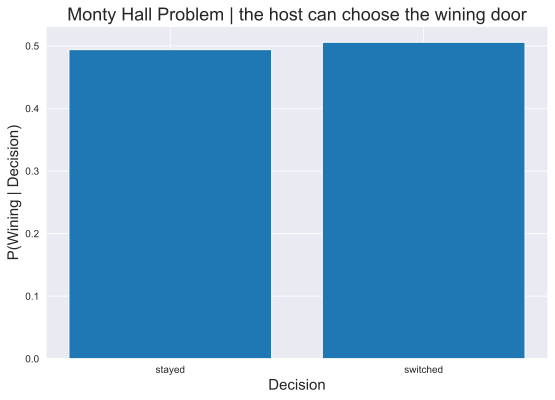

In [6]:
# We look only in the cases where the host doesn't reveal the winning door
switched = 0
stayed = 0
gains = {"stayed" : 0, "switched" : 0}
nbsimu = 0
for nbsim in range(10001) :
    # there are three doors in total
    doors = [1,2,3]

    # the car location
    carLocation = random.randint(1,3)
    
    # Your choice
    choice = random.randint(1,3)
    
    # The host can't choose your door
    doors.remove(choice)
        
    # The host's choice :
    host = random.choice(doors)
    
    # the host opens one of the two remaining doors revealing a goat
    if host != carLocation :
        nbsimu +=1
        # if you made the right choice in the first place
        if choice == carLocation :
            gains["stayed"] += 1
        else :
            gains["switched"] += 1
        
gains["stayed"] = gains["stayed"] / nbsimu
gains["switched"] = gains["switched"] / nbsimu



#style du plot
sns.set_style('darkgrid')
#taille des lables
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
#taille de la figure
plt.figure(figsize=(9,6), dpi = 100)
plt.xlabel('Decision', fontsize = 15)
plt.ylabel('P(Wining | Decision)', fontsize=15)
#titre
plt.title('Monty Hall Problem | the host can choose the wining door', fontsize=18)
plt.bar(gains.keys(), gains.values())
plt.show()

And in this case : <br>
 $P(wining \mid swithed) = \frac{1}{2}$ <br>
 $P(wining \mid stayed) = \frac{1}{2}$ <br>

### causal diagram for Version 2 
Since the host can open any door apart from the one you chose, "Location of the car" is no longer a cause of "Door opened. The corresponding causal diagram is the following:

In [7]:
v2 = gum.fastBN("Your Door[1,3]->Door opened[1,3];Location of the car[1,3]")
v2

(pyAgrum.BayesNet@0x1168bd800) BN{nodes: 3, arcs: 1, domainSize: 27, dim: 10, mem: 120o}

In [8]:
# You randomly pick a door
v2.cpt("Your Door")[:] = [1/3,1/3,1/3]
# The car is randomly assigned
v2.cpt("Location of the car")[:] = [1/3,1/3,1/3]

# The host can't pick your door
v2.cpt("Door opened")[{'Your Door':'1'}] = [0,0.5,0.5] 
v2.cpt("Door opened")[{'Your Door':'2'}] = [0.5,0,0.5]
v2.cpt("Door opened")[{'Your Door':'3'}] = [0.5,0.5,0]

Suppose that you choose door number 1, and the host opens door number 3 revealing a goat:

The host chooses randomly between the remaining doors:

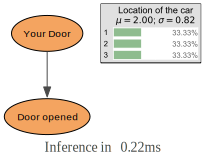

In [9]:
gnb.showInference(v2,targets={"Location of the car"}, evs = {'Your Door':'1', 'Door opened': '3'})

In the beginning, I have to choose between three doors with no prior knowledge:
$P(Location Of The Car = 1) = \frac{1}{3}$        $P(Location Of The Car = 2) = \frac{1}{3}$       $P(Location Of The Car = 3) = \frac{1}{3}$ <br>
I choose to open door number 1.

The host randomly opens door number 3. We get: <br>
$P(DoorOpened = 3 \mid LocationOfTheCar = 3) = \frac{1}{2}$   $P(DoorOpened = 3 \mid LocationOfTheCar = 2) = \frac{1}{2}$    $P(DoorOpened = 3 \mid LocationOfTheCar = 1) = \frac{1}{2}$ 

We apply Bayes' rule:
$P(LocationOfTheCar = 2 \mid DoorOpened = 3) = \frac{P(DoorOpened = 3 \mid LocationOfTheCar = 2)\times P(LocationOfTheCar = 2)}{\sum_{i=1}^{3}{P(DoorOpened = 3 \mid LocationOfTheCar = i) \times P(LocationOfTheCar = i)}} = \frac{\frac{1}{2} \times \frac{1}{3}}{\frac{1}{3} \times (\frac{1}{2}+\frac{1}{2}+\frac{1}{2})} = \frac{1}{3} = P(LocationOfTheCar = 2)$

> In this case, the host chooses randomly between door number 2 and door number 3. Why did he pick door number 3 and not door number 2? There is no reason for his choice. If he revealed the car then, it would mean that you made the wrong choice (You have no chances of winning whether you switched or not.) if he revealed a goat, he was not, in any cases, forced to do so because his choice was completely random. (You have as many chances of winning whether you switched or not.)